# Reconnaissance d'écriture manuscrits

## 1. Importations

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm # for progress bar
import matplotlib.pyplot as plt # for plotting
from PIL import Image # for image reading
import os
import random

## 2. Configuration du matériel

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

if torch.cuda.is_available():
    print("Le GPU est utilisé")
else:
    print("Le GPU n'est PAS utilisé, le CPU est utilisé")

#? paramètre de matplotlib
# plt.rcParams.update({
#     "figure.facecolor": "#1E1E1E",  # Couleur de fond de la figure
#     "axes.facecolor": "#1E1E1E",    # Couleur de fond des axes
#     "axes.edgecolor": "white",      # Couleur des bords des axes
#     "axes.titlecolor": "white",     # Couleur du titre des axes
#     "axes.labelcolor": "white",     # Couleur des étiquettes des axes
#     "xtick.color": "white",         # Couleur des graduations des abscisses
#     "ytick.color": "white",         # Couleur des graduations des ordonnées
#     "text.color": "white",          # Couleur du texte
# })

## 3. Importations des données

In [39]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Chargement des datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Séparation des données d'entraînement en ensembles d'entraînement et de validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Création des DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 4. Exploration des données

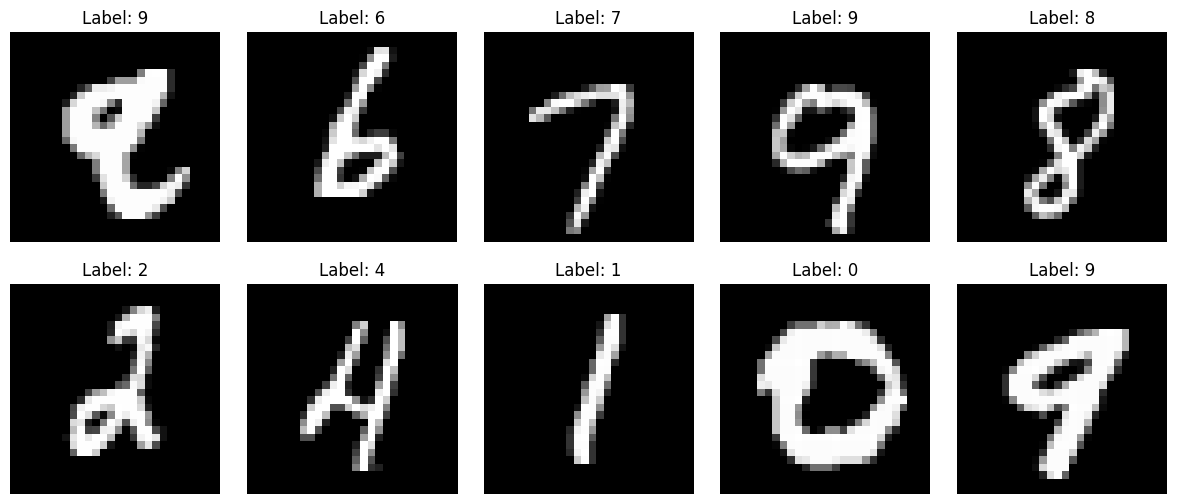

In [40]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Sélectionner 10 indices aléatoires depuis le batch
random_indices = random.sample(range(batch_size), 10)

plt.figure(figsize=(15, 6))  # Définir la taille du plot global

# Boucle à travers les indices aléatoires et affiche l'image et l'étiquette correspondante
for i, idx in enumerate(random_indices):
    image = images[idx].squeeze(0).numpy()  # Retirer la dimension de couleur et convertir en NumPy
    label = labels[idx].item()  # Récupérer l'étiquette comme un entier Python standard
    
    plt.subplot(2, 5, i + 1)  # 2 lignes et 5 colonnes
    plt.imshow(image, cmap='gray')  # Afficher l'image en niveaux de gris
    plt.title(f"Label: {label}")  # Afficher l'étiquette comme titre
    plt.axis('off')  # Désactiver les axes pour une meilleure visibilité

plt.subplots_adjust(wspace=0.1)
plt.show()

## 5. Définition de l'architecture du réseau

In [41]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=40, output_size=10, num_hidden_layers=4):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size, bias=True))
        for i in range(num_hidden_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size, bias=True))
        self.layers.append(nn.Linear(hidden_size, output_size, bias=True))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Mettre à plat les images
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

## 6. Entraînement du modèle!

In [42]:
model = MLP().to(device) # Création du modèle et le charger sur le GPU si disponible
criterion = nn.CrossEntropyLoss() # L& CrossEntropyLoss est notre fonction de perte
optimizer = optim.SGD(model.parameters(), lr=0.01) # lr = learning rate, SGD = Stochastic Gradient Descent

# Entraînement du modèle
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_losses.append(train_loss/len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_losses.append(val_loss/len(val_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

Epoch 1: 100%|██████████| 1500/1500 [00:04<00:00, 324.29it/s]


Epoch [1/20], Train Loss: 2.0999, Val Loss: 1.1956


Epoch 2: 100%|██████████| 1500/1500 [00:04<00:00, 326.55it/s]


Epoch [2/20], Train Loss: 0.7721, Val Loss: 0.5000


Epoch 3: 100%|██████████| 1500/1500 [00:04<00:00, 331.27it/s]


Epoch [3/20], Train Loss: 0.4392, Val Loss: 0.3596


Epoch 4: 100%|██████████| 1500/1500 [00:04<00:00, 334.95it/s]


Epoch [4/20], Train Loss: 0.3277, Val Loss: 0.2669


Epoch 5: 100%|██████████| 1500/1500 [00:04<00:00, 326.45it/s]


Epoch [5/20], Train Loss: 0.2679, Val Loss: 0.2407


Epoch 6: 100%|██████████| 1500/1500 [00:04<00:00, 341.62it/s]


Epoch [6/20], Train Loss: 0.2309, Val Loss: 0.2309


Epoch 7: 100%|██████████| 1500/1500 [00:04<00:00, 332.00it/s]


Epoch [7/20], Train Loss: 0.2037, Val Loss: 0.2034


Epoch 8: 100%|██████████| 1500/1500 [00:04<00:00, 347.68it/s]


Epoch [8/20], Train Loss: 0.1838, Val Loss: 0.1716


Epoch 9: 100%|██████████| 1500/1500 [00:04<00:00, 325.72it/s]


Epoch [9/20], Train Loss: 0.1675, Val Loss: 0.1741


Epoch 10: 100%|██████████| 1500/1500 [00:04<00:00, 332.13it/s]


Epoch [10/20], Train Loss: 0.1549, Val Loss: 0.1598


Epoch 11: 100%|██████████| 1500/1500 [00:04<00:00, 320.32it/s]


Epoch [11/20], Train Loss: 0.1439, Val Loss: 0.1448


Epoch 12: 100%|██████████| 1500/1500 [00:04<00:00, 323.08it/s]


Epoch [12/20], Train Loss: 0.1346, Val Loss: 0.1451


Epoch 13: 100%|██████████| 1500/1500 [00:04<00:00, 322.04it/s]


Epoch [13/20], Train Loss: 0.1262, Val Loss: 0.1485


Epoch 14: 100%|██████████| 1500/1500 [00:04<00:00, 324.17it/s]


Epoch [14/20], Train Loss: 0.1191, Val Loss: 0.1594


Epoch 15: 100%|██████████| 1500/1500 [00:04<00:00, 321.46it/s]


Epoch [15/20], Train Loss: 0.1134, Val Loss: 0.1345


Epoch 16: 100%|██████████| 1500/1500 [00:04<00:00, 323.78it/s]


Epoch [16/20], Train Loss: 0.1083, Val Loss: 0.1203


Epoch 17: 100%|██████████| 1500/1500 [00:04<00:00, 324.41it/s]


Epoch [17/20], Train Loss: 0.1025, Val Loss: 0.1295


Epoch 18: 100%|██████████| 1500/1500 [00:04<00:00, 320.88it/s]


Epoch [18/20], Train Loss: 0.0994, Val Loss: 0.1209


Epoch 19: 100%|██████████| 1500/1500 [00:04<00:00, 325.31it/s]


Epoch [19/20], Train Loss: 0.0945, Val Loss: 0.1177


Epoch 20: 100%|██████████| 1500/1500 [00:04<00:00, 326.10it/s]


Epoch [20/20], Train Loss: 0.0905, Val Loss: 0.1220


## 7. Évaluation du modèle

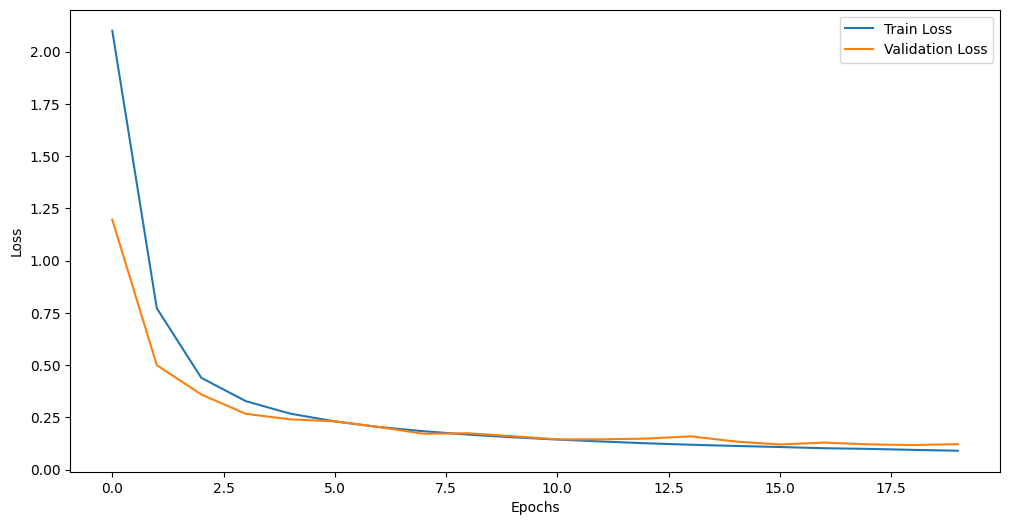

Entraînement terminé


In [43]:
# Affichage des pertes d'entraînement et de validation
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('Entraînement terminé')

## 8. Prédiction sur l'ensemble de test

In [44]:
# Évaluation du modèle
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Précision sur l\'ensemble de test : {accuracy:.2f}%')

Précision sur l'ensemble de test : 96.34%


## 9. Visualisation des prédictions

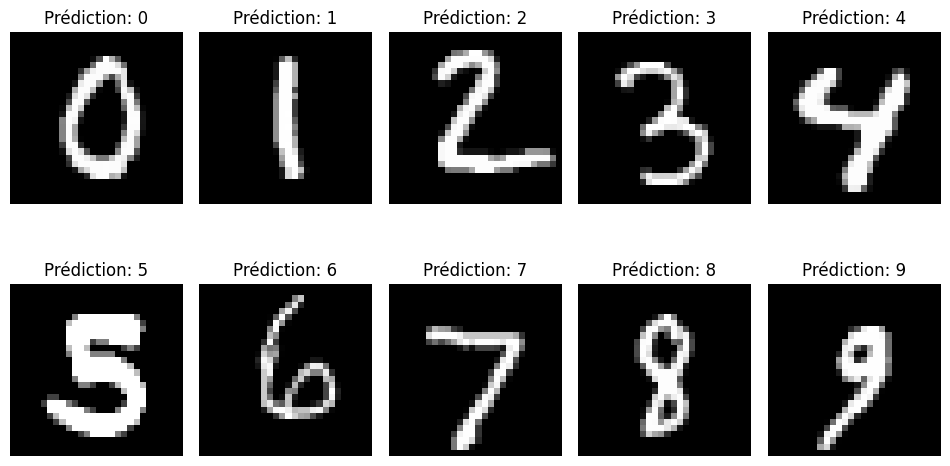

In [45]:
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('L')  # Convertir l'image en niveaux de gris
    image_tensor = transform(image).unsqueeze(0).to(device)  # Transformation et ajout de la dimension de batch
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    return predicted.item(), image  # Retournez la prédiction et l'image ouverte

# Répertoire contenant les images à tester
image_directory = "./data/MNIST/testing"

# Listez tous les fichiers dans le répertoire
all_files = os.listdir(image_directory)

# Filtrez la liste pour n'inclure que les fichiers .png
image_files = [f for f in all_files if f.endswith('.png')]

# Exécutez la prédiction sur toutes les images
plt.figure(figsize=(12, 6))  # Définir la taille du plot global
for i, image_file in enumerate(image_files[:10]):  # Limiter à 10 images
    full_image_path = os.path.join(image_directory, image_file)
    prediction, image = predict_image(full_image_path, model, transform)  # Obtenir la prédictimj et faon et l'image
    
    # Création d'un subplot dans une grille 2x5 (2 lignes et 5 colonnes)
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')  # Afficher l'image en niveaux de gris
    plt.title(f"Prédiction: {prediction}")  # Afficher la prédiction comme titre
    plt.axis('off')  # Supprimer les axes pour une meilleure visibilité

plt.subplots_adjust(wspace=0.1)  # Ajustement de l'espace entre les plots
plt.show()  # Afficher le plot global